In [1]:
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pickle


f2 = open('data/split_0.80_0.10_0.10_aug_to_5000_down_sample_True_instance1/val_data', 'rb')
X_sequence_val, X_feature_val, X_image_val, Y_val = pickle.load(f2)
f2.close()
f3 = open('data/split_0.80_0.10_0.10_aug_to_5000_down_sample_True_instance1/test_data', 'rb')
X_sequence_test, X_feature_test, X_image_test, Y_test = pickle.load(f3)
f3.close()
from keras.preprocessing.sequence import pad_sequences
X_sequence_test_paded = pad_sequences(X_sequence_test, dtype='float', padding='post', value = np.nan)
X_sequence_val_paded = pad_sequences(X_sequence_val, dtype='float', padding='post', value = np.nan)
from util import preprocess
X_sequence_test_trimed = preprocess(X_sequence_test_paded)
X_sequence_val_trimed = preprocess(X_sequence_val_paded)

def build_channel(data):
    X = []
    for image in data:
        X.append(image.reshape(128, 128, 1))
    return X
X_image_test = np.array(build_channel(X_image_test))
X_image_val = np.array(build_channel(X_image_val))
X_feature_test = np.array(X_feature_test)
X_feature_val = np.array(X_feature_val)
Y_test = np.array(Y_test)-1
Y_val = np.array(Y_val)-1

In [6]:
models = []
for i in range(0,10):
    lodaed_model = keras.models.load_model('models/bagging/rnn_with_feature%d/model_4'%i)
    models.append(lodaed_model)

2022-10-19 18:23:58.552119: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-19 18:23:58.561844: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-19 18:23:58.721271: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-19 18:23:59.031549: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-19 18:23:59.080966: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 4 outputs but the _output_sh

(11, 11)
Normalized confusion matrix
[[7.77777778e-01 2.31481481e-03 6.94444444e-03 1.43518519e-01
  2.31481481e-03 0.00000000e+00 4.62962963e-03 0.00000000e+00
  0.00000000e+00 5.78703704e-02 4.62962963e-03]
 [5.33333333e-03 8.72000000e-01 1.04000000e-01 0.00000000e+00
  5.33333333e-03 0.00000000e+00 5.33333333e-03 0.00000000e+00
  8.00000000e-03 0.00000000e+00 0.00000000e+00]
 [6.00000000e-02 1.40000000e-01 7.60000000e-01 2.00000000e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.00000000e-02 0.00000000e+00]
 [1.17647059e-01 0.00000000e+00 0.00000000e+00 8.82352941e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.31914894e-04 5.31914894e-04 5.31914894e-04 0.00000000e+00
  7.62234043e-01 5.90425532e-02 1.72340426e-01 5.31914894e-04
  0.00000000e+00 2.12765957e-03 2.12765957e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.11111111e-02 9.64444444e-01 4.4444444

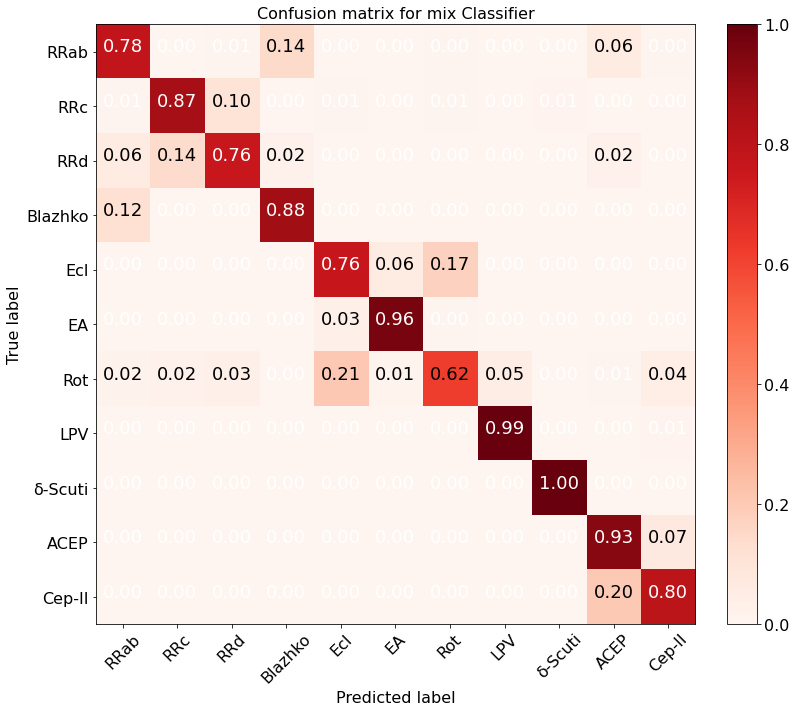

In [7]:

def generate_batch(X_sequence, X_image,  X_feature, Y, batch_size):
    idx = 0
    batch_num = len(Y)/batch_size
    while idx < batch_num:
        batch_x_sequence = X_sequence[idx * batch_size : (idx + 1) * batch_size]
        batch_x_image = X_image[idx * batch_size : (idx + 1) * batch_size]
        batch_x_feature = X_feature[idx * batch_size : (idx + 1) * batch_size]
        batch_y = Y[idx * batch_size : (idx + 1) * batch_size]
        yield batch_x_sequence, batch_x_image, batch_x_feature, batch_y
        idx += 1

test_gen = generate_batch(X_sequence_test_trimed, X_image_test, X_feature_test, Y_test, 128)      
y_label = Y_test

# val_gen = generate_batch(X_sequence_val_trimed, X_image_val, X_feature_val, Y_val, 128)      
# y_label = Y_val


y_predict = np.array([])
for x_sequence, x_image, x_feature, y in test_gen:
    results = []
    for model in models:
        results.append(model.predict({'sequence':x_sequence, 
                                        # 'image':x_image,
                                        'feature':x_feature}))
    average_result = np.sum(results, axis=0)
    y_predict = np.concatenate([y_predict, np.argmax(average_result, axis=-1)])
y_label = y_label.astype(np.int32) 
y_predict = y_predict.astype(np.int32) 
cm = confusion_matrix(y_true=y_label, y_pred=y_predict, normalize='true')
print(cm.shape)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(values_format='.2g')

classes = ['RRab', 'RRc','RRd', 'Blazhko','Ecl', 'EA' , 'Rot', 'LPV','δ-Scuti','ACEP', 'Cep-II']

from util import cm_plot

plotting = cm_plot(cm, classes_types=classes, classifier_model='mix Classifier', nClasses=12,
                    cmap=plt.cm.Blues)